In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
#import cmsisdsp as dsp
import random

import sys
sys.path.append('/home/mat/dev/cached_dilated_causal_convolutions/') 

from cmsisdsp_py_version.block import Block
from cmsisdsp_py_version.keras_model import create_dilated_model
from cmsisdsp_py_version.cached_block_model import CachedBlockModel, Classifier
from cmsisdsp_py_version.rolling_cache import RollingCache


2023-09-07 18:12:01.467711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def parse(fname):
    df_w = pd.read_csv(fname, sep=' ', names=['in', 'out_l', 'out_r'])
    df_w['n'] = range(len(df_w))
    df_l = df_w.melt(id_vars='n', value_vars=['in', 'out_l', 'out_r'])
    return df_w, df_l

sine_df_w, sine_df_l = parse('../datalogger_firmware/sine.ssv')
saw_df_w, saw_df_l = parse('../datalogger_firmware/saw.ssv')
square_df_w, square_df_l = parse('../datalogger_firmware/square.ssv')

/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

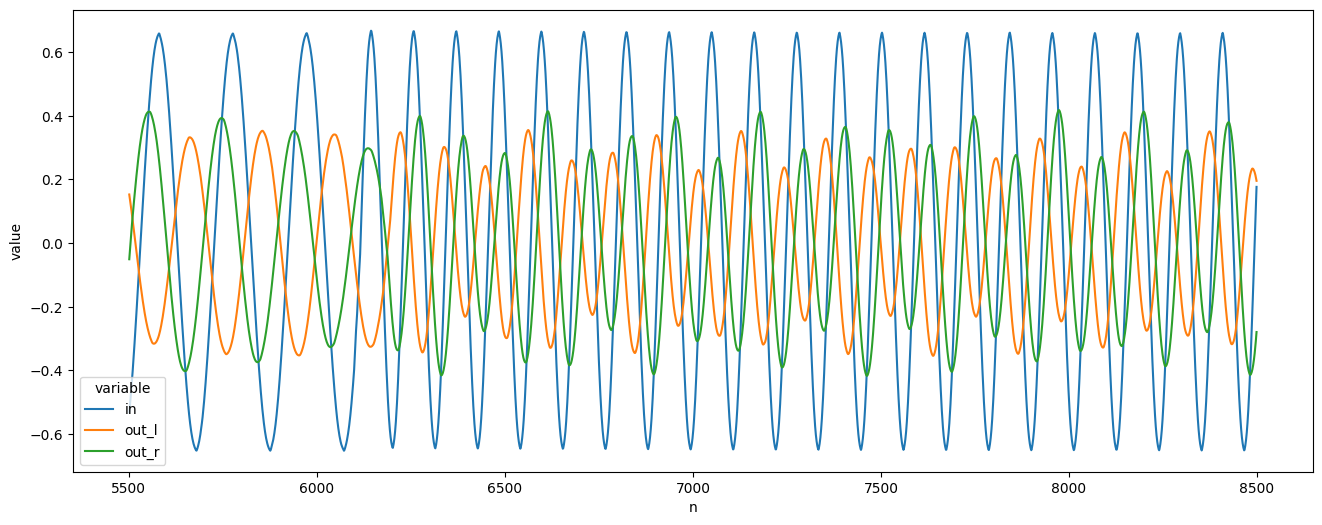

In [3]:
plt.figure(figsize=(16, 6))
offset = 5500
width = 3000
df = sine_df_l
window = (df['n']>offset) & (df['n']<offset+width)
sns.lineplot(df[window], x='n', y='value', hue='variable')

/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

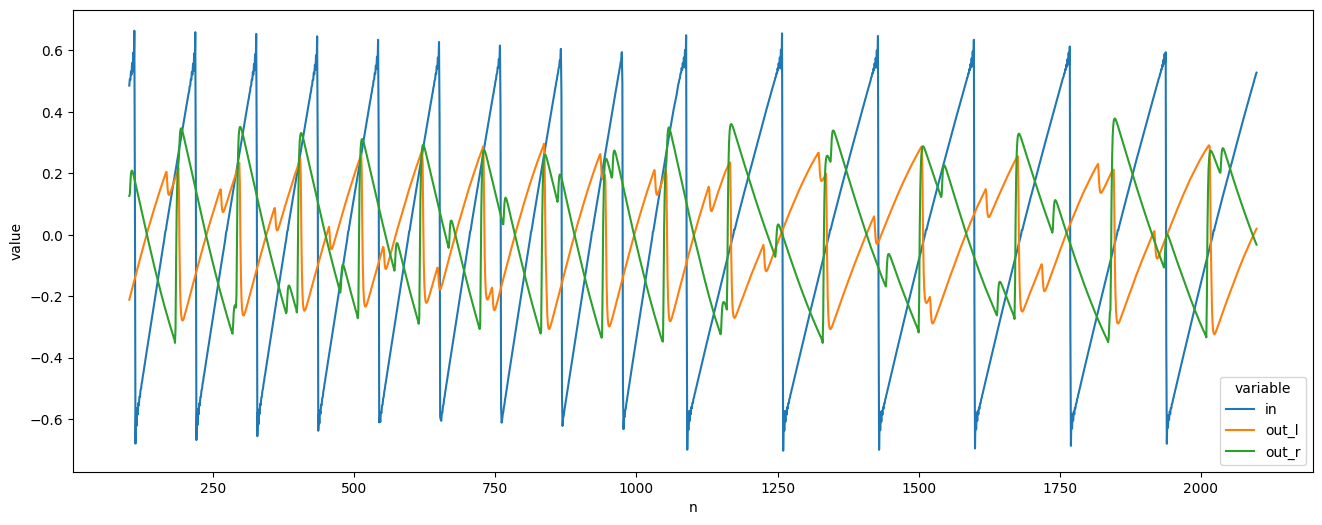

In [4]:
plt.figure(figsize=(16, 6))
offset = 100
width = 2000
df = saw_df_l
window = (df['n']>offset) & (df['n']<offset+width)
sns.lineplot(df[window], x='n', y='value', hue='variable')

some super weird stuff going on with the square wave :)

/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

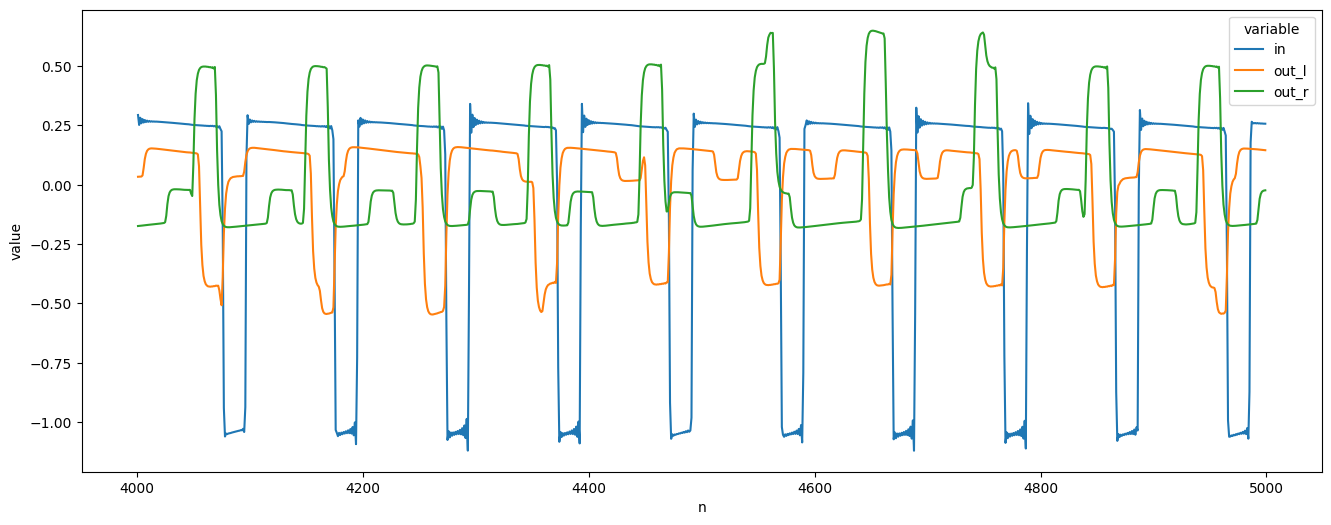

In [5]:
plt.figure(figsize=(16, 6))
offset = 4000
width = 1000
df = square_df_l
window = (df['n']>offset) & (df['n']<offset+width)
sns.lineplot(df[window], x='n', y='value', hue='variable')

training with sine worked, but the wave was boring
let's try the square next

In [107]:
data = square_df_w.to_numpy()
assert data.shape[1] == 4  # 4 columns
x = data[:,0:1]
y_true = data[:,1:3]

x.shape, x[:5], y_true.shape, y_true[:5]

((1280000, 1),
 array([[0.43636394],
        [0.44826986],
        [0.43823123],
        [0.44559718],
        [0.4388175 ]]),
 (1280000, 2),
 array([[ 0.12449885, -0.2896881 ],
        [ 0.12449122, -0.28877638],
        [ 0.12466502, -0.28808355],
        [ 0.12474823, -0.28735709],
        [ 0.12462402, -0.2864847 ]]))

In [108]:
split = int(len(x) * 0.05)
train_x, train_y = x[:(2*-split)], y_true[:(2*-split)]
validate_x, validate_y = x[(2*-split):-split], y_true[(2*-split):-split]
test_x, test_y = x[-split:], y_true[-split:]

print(train_x.shape, train_y.shape, validate_x.shape, validate_y.shape, test_x.shape, test_y.shape)

(1152000, 1) (1152000, 2) (64000, 1) (64000, 2) (64000, 1) (64000, 2)


In [106]:
x = [1,2,3,4,5,6,7,8,9,10]
x[:(2*-2)], x[-4:-2], x[-2:]


([1, 2, 3, 4, 5, 6], [7, 8], [9, 10])

In [90]:
# mono in -> stereo out
IN_D = 1
OUT_D = 2

# kernel size and implied dilation rate
K = 4                

# filters for Nth layer Kx1 and 1x1 convs
# [4, 8, 8, 8] @ 32kHz => 82%
# [4, 8, 8, 12] @ 32kHz => 93%
FILTER_SIZES = [4, 8, 8, 12]  

RECEPTIVE_FIELD_SIZE = K**len(FILTER_SIZES)

TEST_SEQ_LEN = RECEPTIVE_FIELD_SIZE
TRAIN_SEQ_LEN = RECEPTIVE_FIELD_SIZE * 10

print("RECEPTIVE_FIELD_SIZE", RECEPTIVE_FIELD_SIZE)
print("TRAIN_SEQ_LEN", TRAIN_SEQ_LEN)
print("TEST_SEQ_LEN", TEST_SEQ_LEN)

RECEPTIVE_FIELD_SIZE 256
TRAIN_SEQ_LEN 2560
TEST_SEQ_LEN 256


In [91]:
def create_configured_keras_model(seq_len, all_outputs):
    return create_dilated_model(
        seq_len, in_d=IN_D, filter_sizes=FILTER_SIZES,
        kernel_size=K, out_d=OUT_D,
        all_outputs=all_outputs)

In [92]:
train_model = create_configured_keras_model(TRAIN_SEQ_LEN, all_outputs=False)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2560, 1)]         0         
                                                                 
 c0a (Conv1D)                (None, 2560, 4)           20        
                                                                 
 c0b (Conv1D)                (None, 2560, 4)           20        
                                                                 
 c1a (Conv1D)                (None, 2560, 8)           136       
                                                                 
 c1b (Conv1D)                (None, 2560, 8)           72        
                                                                 
 c2a (Conv1D)                (None, 2560, 8)           264       
                                                                 
 c2b (Conv1D)                (None, 2560, 8)           72  

we want to ignore the first RECEPTIVE_FIELD_SIZE elements of the loss since they have been fed with left padded data

In [93]:
mask = np.concatenate([np.zeros(RECEPTIVE_FIELD_SIZE), 
                       np.ones(TRAIN_SEQ_LEN-RECEPTIVE_FIELD_SIZE)])
mask = tf.convert_to_tensor(mask.astype(np.float32))

def masked_mse(y_true, y_pred):    
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    return tf.multiply(mse, mask)    


In [109]:
from tensorflow.keras.optimizers import Adam

def dataset_from(x, y):
    def gen():
        print("|instances|=", len(x)-TRAIN_SEQ_LEN-1)
        for i in range(len(x)-TRAIN_SEQ_LEN-1):
            yield x[i:i+TRAIN_SEQ_LEN], y[i+1:i+1+TRAIN_SEQ_LEN]
                
    ds = tf.data.Dataset.from_generator(
        gen, output_signature=(tf.TensorSpec(shape=(TRAIN_SEQ_LEN, IN_D), dtype=tf.float32),
                               tf.TensorSpec(shape=(TRAIN_SEQ_LEN, OUT_D), dtype=tf.float32)))
    return ds
    
train_ds = dataset_from(train_x, train_y)
train_ds = train_ds.cache().shuffle(10000).batch(128).prefetch(tf.data.AUTOTUNE)

validate_ds = dataset_from(validate_x, validate_y)
validate_ds = validate_ds.cache().batch(128).prefetch(tf.data.AUTOTUNE)

train_model.compile(Adam(1e-4), loss=masked_mse)
train_model.fit(train_ds, 
                validation_data=validate_ds,
                epochs=3)

Epoch 1/3
|instances|= 1149439
   8980/Unknown - 111s 12ms/step - loss: 0.0040|instances|= 61439
8980/8980 [==============================] - 117s 13ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 2/3
8980/8980 [==============================] - 58s 6ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 3/3
8980/8980 [==============================] - 58s 6ms/step - loss: 0.0040 - val_loss: 0.0041


In [35]:
train_model.save("trained_models/saw")

INFO:tensorflow:Assets written to: trained_models/saw/assets


INFO:tensorflow:Assets written to: trained_models/saw/assets


# check against test data


In [83]:
test_records = []

for i in range(2000, 3000):
    test_seq = test_x[i:i+TRAIN_SEQ_LEN]
    test_seq = np.expand_dims(test_seq, 0)  # single element batch
    
    y_true = test_y[i+TRAIN_SEQ_LEN]
            
    y_pred = train_model(test_seq).numpy().squeeze()
    y_pred = y_pred[-1]  # train model gives all steps, we just want last
    
    for c in range(2):
        test_records.append((i, c, 'test_x', test_seq[0,-1,0])) 
        test_records.append((i, c, 'y_true', y_true[c]))
        test_records.append((i, c, 'y_pred', y_pred[c]))
    
test_df = pd.DataFrame(test_records, columns=['n', 'c', 'name', 'value'])
test_df.head()

,n,c,name,value
0,2000,0,test_x,0.093138
1,2000,0,y_true,-0.219014
2,2000,0,y_pred,-0.263366
3,2000,1,test_x,0.093138
4,2000,1,y_true,0.276601


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

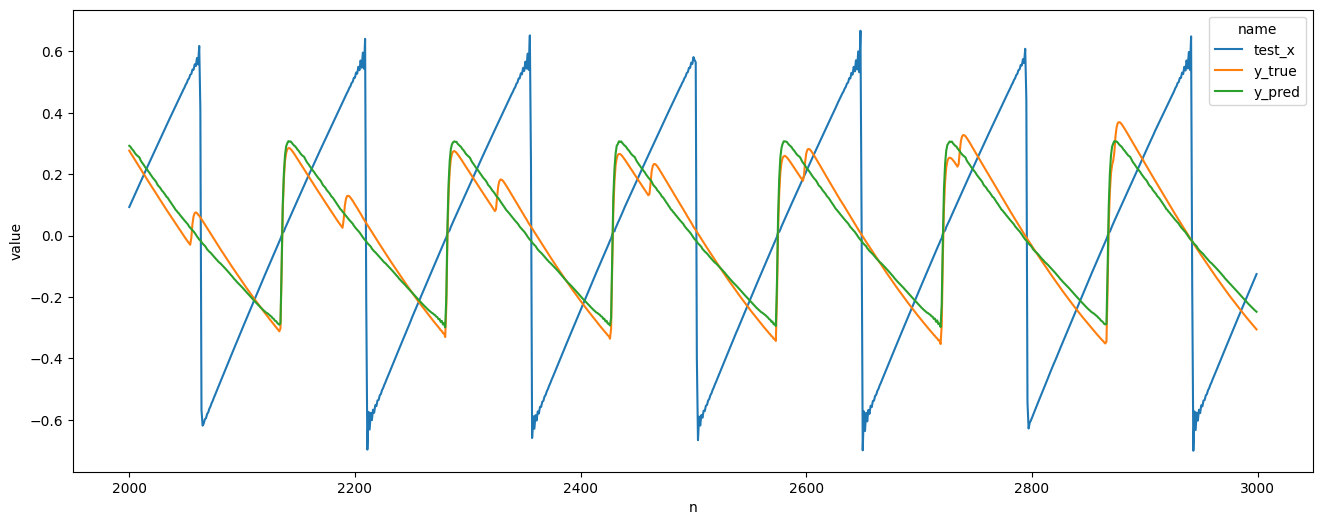

In [84]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=test_df[test_df['c']==1], x='n', y='value', hue='name')

## generate code

hacktastically generate some blocks of c++ code for the inference

In [36]:
assert len(train_model.layers) == 10, len(train_model.layers)

# layer[0] is input

blocks = [
    Block(
        c1_kernel = train_model.layers[1].weights[0].numpy(),
        c1_bias = train_model.layers[1].weights[1].numpy(),
        c2_kernel = train_model.layers[2].weights[0].numpy(),
        c2_bias = train_model.layers[2].weights[1].numpy(),
    ),
    Block(
        c1_kernel = train_model.layers[3].weights[0].numpy(),
        c1_bias = train_model.layers[3].weights[1].numpy(),
        c2_kernel = train_model.layers[4].weights[0].numpy(),
        c2_bias = train_model.layers[4].weights[1].numpy(),
    ),
    Block(
        c1_kernel = train_model.layers[5].weights[0].numpy(),
        c1_bias = train_model.layers[5].weights[1].numpy(),
        c2_kernel = train_model.layers[6].weights[0].numpy(),
        c2_bias = train_model.layers[6].weights[1].numpy(),
    ),
    Block(
        c1_kernel = train_model.layers[7].weights[0].numpy(),
        c1_bias = train_model.layers[7].weights[1].numpy(),
        c2_kernel = train_model.layers[8].weights[0].numpy(),
        c2_bias = train_model.layers[8].weights[1].numpy(),
    )
]

classifier = Classifier(
    weights=train_model.layers[9].weights[0].numpy()[0],
    biases=train_model.layers[9].weights[1].numpy()   
)

# create CachedBlockModel since it creates correct layer
# caches
cached_block_model = CachedBlockModel(
    blocks=blocks,
    input_feature_depth=IN_D,
    classifier=classifier
)      

with open("/tmp/model_defn.h", 'w') as f:
    cached_block_model.write_model_defn_h(f) #sys.stdout)
